# World Data League 2021

## External links and resources
Paste here all the links to external resources that are necessary to understand and run your code. Add descriptions to make it clear how to use them during evaluation.

## Introduction


Our idea for this challeng was to try and provide actionable insights to the people responsible for distributing the bikes by the different stations. Our teams' experience with similar systems of bycicles in different cities was that the bycicleass are normally moved between stations at night. Because of that, our idea was then to provide insights on a daily basis.

In order to provide these insights, we aggregate the data and make predictions on a daily basis, for each station. More specifically, we are trying to predict the **daily** 'flow' or 'deficit'(difference between demand and supply) of vehicles in each station, and are proposing a strategy for **static repositioning** of vehicles. By means of this strategy, based on the predicted demand for the next day, we would redistribute vehicles, **each night**, from stations that have surplus vehicles to those that are expected to run short of bikes to meet the daily demand. 

In this notebook, we have performed some EDA, and have built a baseline model to predict the daily flow of vehicles in each station. We are also using the city weather data as an additional feature to enhance the baseline model. 

We have also proposed a redistribution algorithm, which, given the forecasts for the next day, would automatically give us the allocation/distribution values for vehicles, from stations of excess to stations of deficit.

Given the allocation values for each station, the admins of the city bike sharing system will be charged with the responsibility of actually transporting the vehicles from one station to another. This transportation should be done once a day, preferably at night, when there would be less usage of bikes.

## Development


# **Importing Libraries**

!pip install geopandas folium wwo-hist haversine -q

In [80]:
import pandas as pd
import numpy as np
import requests, zipfile, io
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta, date, datetime
import geopandas as gpd
from wwo_hist import retrieve_hist_data
from haversine import haversine, Unit
from sklearn.metrics import mean_squared_error 

#import openweather
import fiona
import os
import sys
import folium
import warnings

warnings.simplefilter(action='ignore')

import requests
import shapely

from zipfile import ZipFile

from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

# **Functions**

In [40]:
def add_lags_diffs(df, date_column, element_colum, prediction_column, n_lag_days = 3):
    df = df.sort_values(date_column)
    df['Previous_day_flow'] = df.groupby([element_colum])[prediction_column].shift()
    
    for i in range(1,n_lag_days+1):
        df[f'Last-{i}_Day_{prediction_column}'] = df.groupby([element_colum])[prediction_column].shift(i+1)
        df[f'Last-{i}_Day_Diff'] = df.groupby([element_colum])[f'Last-{i}_Day_{prediction_column}'].diff()
        
    df = df.dropna()
    return df

def _weather_pd(url):
    url_df = requests.get(weather_req_url).json()
    df1 = pd.json_normalize(url_df['list'], 'weather')
    df2 = pd.json_normalize(url_df['list'])
    df = df2.drop('weather', axis=1).join(df1)
    return df

def treat_lat_lon (df, lat_col, lon_col):
    df[lat_col] = df[lat_col].str.replace(',', '.')
    df[lat_col] = df[lat_col].astype(float)
    df[lon_col] = df[lon_col].str.replace(',', '.')
    df[lon_col] = df[lon_col].astype(float)
    return df

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

def rmse(ytrue, ypred):
    return np.sqrt(mean_squared_error(ytrue, ypred))

def pd_distance(loc1, loc2):
    # distance when loc1 and loc2 are pandas df rows, tho single row
    return haversine(tuple(loc1.values),tuple(loc2.values))

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout
        
def rf_model (n_trees = 1000):
    mean_error = []
    for day in daterange(start_date, end_date):
        train = whole_dataset[(whole_dataset['loan_date'] < day) & (whole_dataset['loan_date'] > cutoff_date)]
        # validation set is only current day
        val = whole_dataset[whole_dataset['loan_date'] == day]
    
        xtr, xts = train.drop(['flow', 'loan_date'], axis=1), val.drop(['flow', 'loan_date'], axis=1)
        ytr, yts = train['flow'].values, val['flow'].values
    
        mdl = RandomForestRegressor(n_estimators=n_trees, n_jobs=-1, random_state=0)
        mdl.fit(xtr, ytr)
        try:
            p = mdl.predict(xts)
        except:
            continue
        
        error = rmse(yts, p)
        
        #print(f'Day {str(day)[:10]} - Error {error}')
        mean_error.append(error)
    print(' Random Forest Mean Error = %.5f' % np.mean(mean_error))
    return p, mdl

def lgb_model(n_preds = 1000):
    mean_error = []
    for day in daterange(start_date, end_date):
        train = whole_dataset[(whole_dataset['loan_date'] < day) & (whole_dataset['loan_date'] > cutoff_date)]
        # validation set is only current day
        val = whole_dataset[whole_dataset['loan_date'] == day]

        xtr, xts = train.drop(['flow', 'loan_date'], axis=1), val.drop(['flow', 'loan_date'], axis=1)
        ytr, yts = train['flow'].values, val['flow'].values

        mdl = LGBMRegressor(n_estimators=n_preds, learning_rate=0.01)
        mdl.fit(xtr, ytr, categorical_feature ='auto')
        try:
            p = mdl.predict(xts)
        except:
            continue

        error = rmse(yts, p)
        #print(f'Day {str(day)[:10]} - Error {error}')
        mean_error.append(error)
    print('LightGBM Mean Error = %.5f' % np.mean(mean_error))

def basic_distribute(surplus_station_id, df):
    # Takes a station id (surplus)
    # Filters df to get it's surplus demand
    # Filters df to get deficit demand stations data
    # Returns a data-frame with station_id, 
    # and demand to be transfered to that station_id (from surplus station)
    surplus_station_demand = df[df['station_id']==surplus_station_id]['net_demand'].iloc[0]
    deficit_station_demand_df = df[(df['station_id']!=surplus_station_id) & (df['net_demand']<0)]
    deficit_station_demand_df['weightage'] = deficit_station_demand_df['net_demand']/deficit_station_demand_df['net_demand'].sum()
    deficit_station_demand_df['to_be_supplied_source'] = surplus_station_id
    deficit_station_demand_df['to_be_supplied_demand'] = np.round(deficit_station_demand_df['weightage']*surplus_station_demand).astype(int)
    final_df = deficit_station_demand_df.copy()
    return final_df

def distribute(surplus_station_id, df):
    # Takes a station id (surplus)
    # Filters df to get it's surplus demand
    # Filters df to get deficit demand stations data
    # Returns a data-frame with station_id, 
    # and demand to be transfered to that station_id (from surplus station)
    
    # We should distribute only a part of surpluse and keep some to absorb demand shocks too.
    
    to_be_distributed_frac = 0.9
    surplus_station_demand = df[df['station_id']==surplus_station_id]['net_demand'].iloc[0]*to_be_distributed_frac
    
    deficit_station_demand_df = df[(df['station_id']!=surplus_station_id) & (df['net_demand']<0)]
    
    # Location consideration
    surplus_station_location = df[df['station_id']==surplus_station_id][['Lat','Lon']].iloc[0]
    deficit_station_demand_df['distance'] = deficit_station_demand_df.apply(lambda row:pd_distance(surplus_station_location,row[['Lat','Lon']]), axis=1)
    deficit_station_demand_df['reciprocal_distance'] = 1/(1e-2+deficit_station_demand_df['distance'])   
    deficit_station_demand_df['demand_weightage'] = deficit_station_demand_df['net_demand']/deficit_station_demand_df['net_demand'].sum()
    deficit_station_demand_df['location_weightage'] = deficit_station_demand_df['reciprocal_distance']/deficit_station_demand_df['reciprocal_distance'].sum()

    #Final weightage geometric mean of both
    deficit_station_demand_df['gm_weightage'] = np.sqrt(deficit_station_demand_df['demand_weightage']*deficit_station_demand_df['location_weightage'])
    
    # Normalize
    deficit_station_demand_df['weightage'] = deficit_station_demand_df['gm_weightage']/deficit_station_demand_df['gm_weightage'].sum()
    
    #deficit_station_demand_df['weightage'] = deficit_station_demand_df['net_demand']/deficit_station_demand_df['net_demand'].sum()
    deficit_station_demand_df['to_be_supplied_source'] = surplus_station_id
    deficit_station_demand_df['to_be_supplied_demand'] = np.round(deficit_station_demand_df['weightage']*surplus_station_demand).astype(int)
    
    # Not to be more than net demand
    deficit_station_demand_df['to_be_supplied_demand'] = np.where(deficit_station_demand_df['to_be_supplied_demand']>
                                                                  abs(deficit_station_demand_df['net_demand']),
                                                                 abs(deficit_station_demand_df['net_demand']),
                                                                deficit_station_demand_df['to_be_supplied_demand'])
    
    final_df = deficit_station_demand_df.copy()
    return final_df

def distribute_all_stations(core_function):
    # Run on every row and then append
    final_df = pd.DataFrame()
    i = 0
    for idx,row in demand_pred.iterrows():
        if row.net_demand>0:
            surplus_station_id = row.station_id
            df = core_function(surplus_station_id, demand_pred)
            final_df = final_df.append(df)
    
    # Matrix form
    final_df_pivot =  final_df.pivot_table(index = 'to_be_supplied_source',
                                     columns = 'station_id',
                                     values = 'to_be_supplied_demand')
    return final_df_pivot

# **Loading Data**

In [13]:
bike_stations = pd.read_csv('https://wdl-data.fra1.digitaloceanspaces.com/medellin/station_location_with_id.csv', encoding='Latin-1', error_bad_lines=False, sep=';')
bike_stations = treat_lat_lon (bike_stations, 'Lat', 'Lon')

In [17]:
#loans = pd.read_csv('/content/drive/MyDrive/WDL/bike_loans.csv', sep=';')
loans = pd.read_csv('/home/primity/wdl3data/bike_loans.csv', sep=';')

In [20]:
loans['loan_date']=loans['Fecha_Prestamo'].str[:10]
loans = loans.rename(columns = {'Id_Historico_Prestamo': 'loan_id', 'Id_Usuario':'user_id', 'Id_Tag_Bicicleta':'bike_id', 'Id_Aparcamiento_Origen':'origin_id', 'Id_Aparcamiento_Destino':'dest_id'})

## Bike Stations

In [233]:
f = folium.Figure(width=500, height=700)
m = folium.Map(
    location=[6.22, -75.58],
    zoom_start=12,
    control_scale=True,
    zoom_control=False,
    min_zoom=12
    )
for i in range(len(bike_stations)):
    folium.CircleMarker([bike_stations.iloc[i]['Lat'], bike_stations.iloc[i]['Lon']], color='blue', radius=2).add_to(m)
f.add_child(m)
f

We can see that the bike stations are roughly separated between two areas in the city.

There are some cases where the return date is before the loan date. Since there are not too many of these cases (only 3895) we can remove them with no issues.

In [105]:
loans = loans[loans.Fecha_Prestamo < loans.Fecha_Devolucion]

# **Aggregating and Merging Loans Data for prediction**

Since we will be predicting the surplus of deficit of bikes after a whole day, we must perform daily aggregations of the Loans data. For that, we'll be grouping by origin and destination 

In [22]:
day_station_origin = loans.groupby(['loan_date', 'origin_id'])['loan_id'].agg('count').reset_index(name="loans_day_origin").rename(columns={'origin_id':'station_id'})
day_station_dest = loans.groupby(['loan_date', 'dest_id'])['loan_id'].agg('count').reset_index(name="loans_day_dest").rename(columns={'dest_id':'station_id'})

In [27]:
day_station = day_station_origin.merge(day_station_dest, on=['loan_date', 'station_id'])
day_station['flow'] = day_station.loans_day_dest - day_station.loans_day_origin
day_station = day_station.drop(columns=['loans_day_origin', 'loans_day_dest'])

In [28]:
day_station

loan_date  station_id  flow
0       2014-05-30           1    -1
1       2014-06-01           1     1
2       2014-06-01          10    -2
3       2014-06-02           1     0
4       2014-06-02           2     0
...            ...         ...   ...
105898  2021-04-20         137    -8
105899  2021-04-20         139    -4
105900  2021-04-20         140     3
105901  2021-04-20         141     2
105902  2021-04-20         142     1

[105903 rows x 3 columns]

We now have the **flow** data. This is the number we'll be predicting in out model. We'll be essentially trying to predict multiple time series (one for each station).

# **Adding Features to our Time Series data**

## Lags and Diffs

Now that we have the variable we want to predict, we want to add some features to make it possible for a model to predict the daily flow for each station. There are two types of features which usually are very useful when trying to forecast time series: lags and differences.

Last-x-Day_Intensity: this is simply the amount of sales that a product had in the previous week
Last Week Diff: the difference between the amount of sales in the previous week and the week before it (t-1 - t-2)


In [235]:
time_feats = add_lags_diffs(day_station, 'loan_date', 'station_id', 'flow', 3)
time_feats.head(5)

loan_date  station_id  flow  Previous_day_flow  Last-1_Day_flow  \
35 2014-06-05           1    -4               -7.0            -14.0   
49 2014-06-06           1   -11               -4.0             -7.0   
73 2014-06-09          11    17               10.0              6.0   
72 2014-06-09          10     7                9.0              6.0   
64 2014-06-09           2    25               10.0              5.0   

    Last-1_Day_Diff  Last-2_Day_flow  Last-2_Day_Diff  Last-3_Day_flow  \
35            -14.0              0.0             -1.0              1.0   
49              7.0            -14.0            -14.0              0.0   
73            -35.0             41.0             36.0              5.0   
72             -5.0             11.0            -13.0             24.0   
64             -4.0              9.0             18.0             -9.0   

    Last-3_Day_Diff  
35              2.0  
49             -1.0  
73              5.0  
72             26.0  
64             -9.0

## Weather Data

Since we had problems with OpenWeatherMap, we had to resort to an alternative, and we've decided to use World Weather Online historical data. This service provides averaged daily values for weather. When we were using Open Weather Map's houly time data, we did the averaging ourselves. Also, note that the provided weather values are not the same in both services (i.e. the columns of the weather dataframe are different from what we would get from OWM).

In [43]:
frequency=24
start_date = '31-DEC-2014'
end_date = '20-APR-2021'
api_key = 'b9fcd58f2ad94fcea0a175917211205'
location_list = ['Medellin']

with HiddenPrints():
    hist_weather_data = retrieve_hist_data(api_key,
                                location_list,
                                start_date,
                                end_date,
                                frequency,
                                location_label = False,
                                export_csv = True,
                                store_df = True)

In [62]:
#medellin_data = pd.read_csv('/content/drive/MyDrive/WDL/Medellin.csv')
weather = pd.read_csv('Medellin.csv')

Knowing this data source, we remove some columns we intitively feel won't give a lot of information to the model, such as features related to moon cycles, sunset and sunrise time, direction of wind, snow coverage (aways zero in our data) and pressure.

In [63]:
weather = weather.drop(columns=['location', 'moon_illumination', 'moonrise', 'moonset', 'sunrise',
       'sunset', 'totalSnow_cm', 'pressure', 'winddirDegree'])

We then merge this data with our 'flow' data, which has already been enriched with lags and diff features. This merged dataset includes all the features we'll use in our predictions.

In [88]:
weather_time_feats = time_feats.merge(weather, left_on='loan_date', right_on='date_time').drop(columns=['date_time'])

In [236]:
weather_time_feats.head(5)

loan_date  station_id  flow  Previous_day_flow  Last-1_Day_flow  \
0 2014-12-31          23   -11               -4.0             -2.0   
1 2014-12-31          20     1               -6.0              1.0   
2 2014-12-31          21    -7                4.0              5.0   
3 2014-12-31          22     0               -6.0             -3.0   
4 2014-12-31          24   -12                0.0             -3.0   

   Last-1_Day_Diff  Last-2_Day_flow  Last-2_Day_Diff  Last-3_Day_flow  \
0              5.0             -7.0             -2.0             -5.0   
1             10.0             -9.0             -8.0             -1.0   
2              8.0             -3.0             -5.0              2.0   
3              1.0             -4.0              1.0             -5.0   
4             -8.0              5.0              8.0             -3.0   

   Last-3_Day_Diff  ...  FeelsLikeC  HeatIndexC  WindChillC  WindGustKmph  \
0              1.0  ...          17          18          17             9   
1             -2.0  ...          17          18          17             9   
2              2.0  ...          17          18          17             9   
3              0.0  ...          17          18          17             9   
4              3.0  ...          17          18          17             9   

   cloudcover  humidity  precipMM  tempC  visibility  windspeedKmph  
0          23        78       1.1     23           9              5  
1          23        78       1.1     23           9              5  
2          23        78       1.1     23           9              5  
3          23        78       1.1     23           9              5  
4          23        78       1.1     23           9              5  

[5 rows x 25 columns]

# Models

In [91]:
weather_time_feats['loan_date'] = pd.to_datetime(weather_time_feats['loan_date'])

In [92]:
whole_dataset = weather_time_feats

In [93]:
cutoff_date = datetime(2021, 1, 1)
start_date = datetime(2021, 3, 1)
end_date = datetime(2021, 3, 20)

In [237]:
mean_error = []
for day in daterange(start_date, end_date):
    train = whole_dataset[(whole_dataset['loan_date'] < day) & (whole_dataset['loan_date'] > cutoff_date)]
    # validation set is only current day
    val = whole_dataset[whole_dataset['loan_date'] == day]

    # model is mean of last 3 days
    p = (val['Last-1_Day_flow'].values + val['Previous_day_flow'].values )/2
    try:
        error = rmse(val['flow'].values, p)
    except:
        print(val['flow'].values, p)
    #print(f'Day {str(day)[:10]} - Error {error}')
    mean_error.append(error)
print('Simple Baseline Mean Error = %.5f' % np.mean(mean_error))

[] []
Simple Baseline Mean Error = 9.87828


We'll now try a random forest model. Given that tree-based models will split the numerical data rather than try to perform regression-like operations, we'll keep the station_id field as an integer

In [243]:
rf_preds, rf_mdl = rf_model (n_trees = 1000)

 Random Forest Mean Error = 9.08861


(array([ -0.683,  -0.363,   0.407,  -1.101,   0.569,   2.113,   0.929,
          4.108,   6.724,   0.263,   9.4  ,   0.95 ,   3.878,  20.279,
          2.414,   2.332,  -2.096,  -0.932,   1.358,  -2.204,   7.768,
         -2.449,   0.101,  -1.634,  22.156,   1.002,   4.939,   1.397,
          0.456,  -0.076,   1.427,  -1.004,   0.907,   4.031,   0.58 ,
          0.996,  -1.585,   0.573,   0.379,   0.735,  -0.624,   1.064,
         -2.777,  -2.15 ,   0.126, -72.146,   7.255,   2.021,   2.896,
        -19.306,  -8.944, -35.088,   3.516, -11.188,  -0.807, -52.661,
          1.994, -21.126, -13.828,   5.127, -15.349, -27.834,  14.094,
         13.788, -35.898,   8.441,   4.35 ,   4.209,  55.955,  23.781,
        -27.76 ,   0.559,   9.089,  23.863,   2.073,   2.458,  -2.758,
          2.196,  23.205,  -3.24 ,   8.077,   7.024,  -1.172,   3.055,
          0.102,  -6.331,  21.154,   7.713,   4.691,   5.915,   2.167,
          5.682]),
 RandomForestRegressor(n_estimators=1000, n_jobs=-1, rando

We can see that the prediction from random forest are better than or baseline prediction. Given that reandom forest tends to be relatively stable across different hyperparameter selections, we'll simply increase the number of predictors (we'll experiment with more trees)

In [ ]:
print('==RANDOM FOREST MODEL ==')
print(' ')
for trees in [5000, 7000]:
    print(f'Number of estimators: {trees}')
    rf_preds, rf_mdl =rf_model(n_trees = trees)
    print(' ')

==RANDOM FOREST MODEL ==
 
Number of estimators: 5000


We'll now try the same with a LightGBM model

In [ ]:
print('==LIGHTGBM MODEL ==')
print(' ')
for trees in [5000, 10000]:
    print(f'Number of estimators: {trees}')
    p, lgb_mdl = lgb_model(trees)
    print(' ')

As a simple sanity check, we can see our predictions are well correlated with our actual flow values. If we had a perfect model, the graph would show a straight diagonal line.

<Figure size 288x288 with 0 Axes>

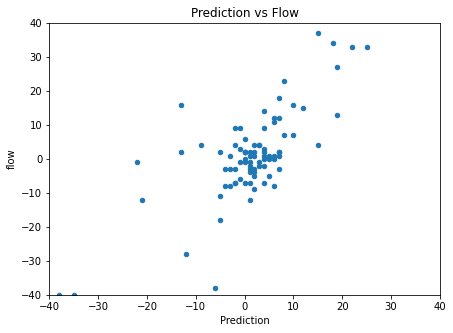

In [129]:
plt.figure(figsize=(4,4))
val.loc[:, 'Prediction'] = np.round(p)
val.plot.scatter(x='Prediction', y='flow', figsize=(7,5), title='Prediction vs Flow', ylim=(-40,40), xlim=(-40,40));

# **Inference for April 20 2021**

To calculate inference for futere days, the weather data can not be obtained from historical data sources. Open Weather Map provides a forecast function, which would normally be used. However, since the API for OSM only provided us with part of the data, we used World Weather Online, which does not provide forecasting data. Regardless, the most recent data point we have is 20 April 2021. Even if we had managed to use OWM, we would not use the forecast API in this case. Nonetheless, this point must be made clear.

In [117]:
last_day = whole_dataset[whole_dataset.loan_date == '2021-04-20']

In [118]:
last_x = last_day.drop(['flow', 'loan_date'], axis=1)
last_y = last_day['flow'].values, z

In [134]:
last_day_preds = mdl.predict(last_x)

In [226]:
demand_pred = last_day[['station_id']]
demand_pred['net_demand'] = [int(round(d)) for d in last_day_preds]

We now have the prediction of flows for each of the stations. In order to provide specific actions (how many bikes must be transported, and to where), we'll be using station location data, which we extract from the provided dataframe.

In [228]:
demand_pred = demand_pred.merge(bike_stations[['ID', 'Lat', 'Lon']], left_on ='station_id', right_on='ID').drop(columns='ID')

In [229]:
demand_pred.head(4)

station_id  net_demand       Lat        Lon
0          97           2  6.250667 -75.568071
1          98           7  6.235250 -75.596473
2         105           9  6.174278 -75.595795
3         100           8  6.238578 -75.590414

We can now plot the stations which had negative demand (number of bikes was reduced) in red and the stations with positive demand in green.

In [231]:
pos_dem = demand_pred[demand_pred.net_demand>=0]
neg_dem = demand_pred[demand_pred.net_demand<0]

f = folium.Figure(width=500, height=700)
m = folium.Map(
    location=[6.22, -75.58],
    zoom_start=12,
    control_scale=True,
    zoom_control=False,
    min_zoom=12
    )

for i in range(len(pos_dem)):
    folium.CircleMarker([pos_dem.iloc[i]['Lat'], pos_dem.iloc[i]['Lon']], color='green', radius=2).add_to(m)

for i in range(len(neg_dem)):
    folium.CircleMarker([neg_dem.iloc[i]['Lat'], neg_dem.iloc[i]['Lon']], color='red', radius=2).add_to(m)
    
f.add_child(m)
f

# **Redistribution of Surplus Bicycles in each station**

Base on the daily surplus or deficit of bikes, we'll now offer actionable suggestions on the best way to move the bikes around. Distribution problems of this kind can get quite complex, and there are many ways to improve efficiency in these distributions. In our case, we'll take the distance between the stations into account (we're using haversine distance, which is a geological distance between two lattitudes and longitudes, as measured on earth's surface).

In [164]:
basic_distribute(1, demand_pred)

station_id  net_demand       Lat        Lon  weightage  \
10          93          -2  6.260431 -75.586168   0.004098   
11          91          -2  6.220060 -75.571400   0.004098   
12          90          -4  6.263380 -75.595092   0.008197   
15          66         -91  6.231406 -75.577222   0.186475   
23         139          -6  6.174198 -75.606902   0.012295   
24         137          -2  6.175772 -75.606025   0.004098   
25         136          -2  6.174860 -75.609418   0.004098   
29         132          -3  6.164182 -75.606183   0.006148   
30         131          -1  6.164172 -75.606290   0.002049   
31         128          -4  6.150029 -75.619176   0.008197   
32         125          -1  6.152328 -75.618236   0.002049   
34         116          -4  6.169116 -75.588429   0.008197   
36         114          -5  6.170588 -75.589395   0.010246   
37         113          -6  6.168662 -75.590867   0.012295   
38         112          -3  6.171670 -75.591061   0.006148   
39         110          -3  6.169980 -75.593300   0.006148   
40         107          -1  6.171228 -75.594110   0.002049   
42          33          -1  6.245512 -75.577011   0.002049   
45          23         -65  6.231326 -75.591538   0.133197   
47          21         -30  6.239151 -75.583073   0.061475   
48          20          -1  6.245383 -75.584008   0.002049   
50          13         -50  6.271922 -75.591324   0.102459   
51          12         -64  6.258628 -75.597366   0.131148   
52          28         -30  6.156829 -75.616668   0.061475   
55           8         -32  6.253349 -75.587692   0.065574   
56           7         -27  6.253003 -75.582687   0.055328   
59           2          -8  6.269267 -75.565300   0.016393   
61         141          -1  6.175649 -75.596444   0.002049   
62          10          -3  6.244998 -75.589188   0.006148   
63          61          -1  6.222324 -75.572961   0.002049   
65          59          -2  6.228510 -75.574658   0.004098   
68          56          -8  6.230550 -75.574373   0.016393   
72          48          -3  6.262189 -75.595039   0.006148   
73          32          -1  6.258327 -75.594235   0.002049   
80          38         -19  6.245062 -75.597297   0.038934   
83          46          -2  6.250549 -75.594719   0.004098   

    to_be_supplied_source  to_be_supplied_demand  
10                      1                      0  
11                      1                      0  
12                      1                      0  
15                      1                     -2  
23                      1                      0  
24                      1                      0  
25                      1                      0  
29                      1                      0  
30                      1                      0  
31                      1                      0  
32                      1                      0  
34                      1                      0  
36                      1                      0  
37                      1                      0  
38                      1                      0  
39                      1                      0  
40                      1                      0  
42                      1                      0  
45                      1                     -2  
47                      1                     -1  
48                      1                      0  
50                      1                     -1  
51                      1                     -2  
52                      1                     -1  
55                      1                     -1  
56                      1                     -1  
59                      1                      0  
61                      1                      0  
62                      1                      0  
63                      1                      0  
65                      1                      0  
68                      1                      0  
72                      1 

In [170]:
distribute(1, demand_pred)

station_id  net_demand       Lat        Lon   distance  \
10          93          -2  6.260431 -75.586168   2.966942   
11          91          -2  6.220060 -75.571400   6.327447   
12          90          -4  6.263380 -75.595092   3.655591   
15          66         -91  6.231406 -75.577222   5.207823   
23         139          -6  6.174198 -75.606902  12.299203   
24         137          -2  6.175772 -75.606025  12.100601   
25         136          -2  6.174860 -75.609418  12.339652   
29         132          -3  6.164182 -75.606183  13.309301   
30         131          -1  6.164172 -75.606290  13.314495   
31         128          -4  6.150029 -75.619176  15.302198   
32         125          -1  6.152328 -75.618236  15.026288   
34         116          -4  6.169116 -75.588429  12.232093   
36         114          -5  6.170588 -75.589395  12.095776   
37         113          -6  6.168662 -75.590867  12.341464   
38         112          -3  6.171670 -75.591061  12.021617   
39         110          -3  6.169980 -75.593300  12.265370   
40         107          -1  6.171228 -75.594110  12.154862   
42          33          -1  6.245512 -75.577011   3.709268   
45          23         -65  6.231326 -75.591538   5.835997   
47          21         -30  6.239151 -75.583073   4.626430   
48          20          -1  6.245383 -75.584008   4.067327   
50          13         -50  6.271922 -75.591324   2.976736   
51          12         -64  6.258628 -75.597366   4.115871   
52          28         -30  6.156829 -75.616668  14.498013   
55           8         -32  6.253349 -75.587692   3.616036   
56           7         -27  6.253003 -75.582687   3.283748   
59           2          -8  6.269267 -75.565300   0.815570   
61         141          -1  6.175649 -75.596444  11.755891   
62          10          -3  6.244998 -75.589188   4.427250   
63          61          -1  6.222324 -75.572961   6.100552   
65          59          -2  6.228510 -75.574658   5.455538   
68          56          -8  6.230550 -75.574373   5.226997   
72          48          -3  6.262189 -75.595039   3.705481   
73          32          -1  6.258327 -75.594235   3.834562   
80          38         -19  6.245062 -75.597297   5.018506   
83          46          -2  6.250549 -75.594719   4.394848   

    reciprocal_distance  demand_weightage  location_weightage  gm_weightage  \
10             0.335915          0.004098            0.047195      0.013908   
11             0.157792          0.004098            0.022169      0.009532   
12             0.272807          0.008197            0.038328      0.017725   
15             0.191651          0.186475            0.026926      0.070859   
23             0.081240          0.012295            0.011414      0.011846   
24             0.082572          0.004098            0.011601      0.006895   
25             0.080974          0.004098            0.011377      0.006828   
29             0.075079          0.006148            0.010548      0.008053   
30             0.075050          0.002049            0.010544      0.004648   
31             0.065307          0.008197            0.009175      0.008672   
32             0.066506          0.002049            0.009344      0.004376   
34             0.081685          0.008197            0.011476      0.009699   
36             0.082605          0.010246            0.011606      0.010905   
37             0.080962          0.012295            0.011375      0.011826   
38             0.083114          0.006148            0.011677      0.008473   
39             0.081464          0.006148            0.011445      0.008388   
40             0.082204          0.002049            0.011549      0.004865   
42             0.268870          0.002049            0.037775      0.008798   
45             0.171057          0.133197            0.024033      0.056578   
47             0.215683          0.061475            0.030303      0.043161   
48             0.245259          0.002049         

We can now have a matrix which describes evary bike transport, between each pair of stations. This amtrix represents our actual insight to the teams that are responsibler for moving the bikes around.

We have a matrix based on our simpler baseline:

In [190]:
basic_distribute_matrix = distribute_all_stations(basic_distribute)

And a matrix based on our more complex distribute function, which takes more factors into account 

In [177]:
distribute_matrix = distribute_all_stations(distribute)
distribute_matrix.sort_values

station_id             1    2    7    8    10   12   13   20   21   23   ...  \
to_be_supplied_source                                                    ...   
3.0                      1    1    1    1    0    1    1    0    1    1  ...   
6.0                      0    0    1    1    0    1    1    0    1    1  ...   
11.0                     0    0    0    0    0    1    0    0    0    0  ...   
19.0                     0    0    1    1    0    1    1    0    1    1  ...   
22.0                     0    0    0    0    0    0    0    0    0    0  ...   
24.0                     0    0    0    0    0    0    0    0    0    0  ...   
36.0                     1    1    3    3    1    4    3    1    4    4  ...   
39.0                     0    0    1    1    1    1    1    0    1    1  ...   
40.0                     0    0    0    0    0    0    0    0    0    0  ...   
42.0                     0    0    0    0    0    0    0    0    0    0  ...   
44.0                     0    0    2    1    0    1    1    0    1    1  ...   
45.0                     0    0    0    0    0    1    0    0    1    2  ...   
47.0                     0    0    0    0    0    0    0    0    0    0  ...   
49.0                     0    0    0    0    0    0    0    0    0    0  ...   
53.0                     0    0    0    1    0    1    0    0    0    0  ...   
55.0                     0    0    0    0    0    1    0    0    0    0  ...   
57.0                     0    0    1    1    0    1    1    0    1    1  ...   
58.0                     0    0    0    0    0    0    0    0    0    0  ...   
60.0                     0    0    0    0    0    0    0    0    0    1  ...   
62.0                     1    1    3    2    0    2    2    0    1    2  ...   
63.0                     0    0    0    0    0    0    0    0    0    1  ...   
64.0                     0    0    1    1    0    1    1    0    1    2  ...   
67.0                     0    0    0    0    0    0    0    0    0    0  ...   
89.0                     1    1    3    3    1    3    3    1    3    4  ...   
92.0                     0    0    0    0    0    0    0    0    0    0  ...   
94.0                     0    0    0    0    0    0    0    0    0    0  ...   
95.0                     0    0    0    0    0    0    0    0    0    0  ...   
96.0                     0    0    1    0    0    1    0    0    0    1  ...   
97.0                     0    0    0    0    0    0    0    0    0    0  ...   
98.0                     0    0    0    0    0    0    0    0    0    1  ...   
99.0                     0    0    0    0    0    0    0    0    1    1  ...   
100.0                    0    0    0    0    0    1    0    0    1    1  ...   
101.0                    0    0    0    0    0    0    0    0    0    0  ...   
102.0                    0    0    0    0    0    1    0    0    1    1  ...   
105.0                    0    0    0    0    0    0    0    0    0    0  ...   
106.0                    0    0    0    0    0    0    0    0    0    0  ...   
109.0                    0    0    0    0    0    0    0    0    0    0  ...   
115.0                    0    0    0    0    0    0    0    0    0    0  ...   
124.0                    0    0    0    0    0    0    0    0    0    0  ...   
126.0                    0    0    0    0    0    0    0    0    0    0  ...   
133.0                    0    0    0    0    0    0    0    0    0    0  ...   
134.0                    0    0    0    0    0    0    0    0    0    0  ...   
140.0                    0    0    0    0    0    0    0    0    0    0  ...   
142.0                    0    0    0    0    0    0    0    0    0    0  ...   

station_id             114  116  125  128  131  132  136  137  139  141  
to_be_supplied_source                                                    
3.0                      0    0    0    0    0    0    0    0    0    0  
6.0                      0    0    0    0    0    0    0    0    0    0  
11.0                   

Based on this table, we can now get the highest numbers of bikes needing to be moves, and present them to the people who should move them. For now, if the number of bikes to move is less than 6, we are leaving the suggestion out.

In [222]:
max_vals_col = []
for col in basic_distribute_matrix.columns:
    max_vals_col.append(basic_distribute_matrix[col].max())

max_vals_dist=sorted(set(max_vals_col))[-5:]

for val in max_vals_dist:
    if val >=5:
        df = basic_distribute_matrix
        movements = [(df[col][df[col].eq(val)].index[i], df.columns.get_loc(col)) for col in df.columns for i in range(len(df[col][df[col].eq(val)].index))]
        for m in movements:
            print(f'Move {val} bikes from station {int(m[0])} to station {m[1]}')
    

Move 5 bikes from station 36 to station 6
Move 5 bikes from station 89 to station 6
Move 5 bikes from station 62 to station 19
Move 7 bikes from station 36 to station 5
Move 7 bikes from station 89 to station 5
Move 7 bikes from station 36 to station 9
Move 7 bikes from station 89 to station 9
Move 10 bikes from station 36 to station 19


## Conclusions

### Scalability and Impact
This is a very scalable solution. It could be applied to other cities with similar bike sharing programs, since it requires no data that is out of the ordinary in a system of this kind. For now, we are only using a small, recent subset of the dataset, and training small models daily. This adds some complexity, and ideally we would have a high-quality model which is changed less often.

### Future Work

 - The dynamics for Manual stations (which have people loaning out bikes) are likely very different from automatic stations. For now, we simply considered whether a station is manual as a feature, but we believe the concerns about number of bikes would be quite different in these stations, assuming they don't have a maximum fixed capacity

 - We have attempted to include elevation data for each bike station, but couldn't find an API or another source to provide the data in time. We believe this feature would offer critical insights, especially in a city with a high altitude (and likely differences in elevation) as Medellin.

 - Some additional analysis of historical data could provide insights on good ways to improve the actual infrastructure of the system, by expanding, reducing, moving, or creating new stations. This analysis would be quite fruitful.
 
 - On the same note, it would be important to cross-reference this data with information about socio-economic factors across different neighbourhoods. This way, we could make sure the system is serving disavantaged in the same way as everyone else. It would also be important to check our model's fairness in this regard, making sure e.g. it's not taking too many bikes away from poorer areas of the city.

 - When redistributing bikes across the city, every station movement, also has a fixed truck rent/fuel/driver cost. We should consideer this when making suggestions on moving bikes around.
    - We should try to make it so that trucks are as full as possible, and that distance travelled is minimized. We must also take into account the number of bikes each truck can move at at time.
    - When considering the distance travelled by the trucks, taking into account that the truck has some stations it needs to visit, this becomes a variation of the travelling salesman problem, which has been the focus of a lot of research     


- We should also present more suggestions related to the actual route to be followed when distributing the bikes, and plot it on a map. Ideally, the sugegestions would look like:
    - Drive to station 5 and pick up 10 bikes
    - Drive to station 2 and pick up 2 bikes
    - Drive to station 14 and drop 7 bikes
    - Drive to station 20 and pick up 5 bikes
    - Drive to station 8 and drop 8 bikes
    - Drive to station 20 and drop 2 bikes
    - Distribution complete  

- And it would represent the most efficient way to perform this bike distribution